# Baryonic Modules in pyCCL

Some basic information about baryonic models in pyccl v3

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogFormatterMathtext
import numpy as np
import pyccl as ccl

Initialisation of cosmology object and scales

In [2]:
cosmology_vanilla = ccl.CosmologyVanillaLCDM()  # cosmology object
k = np.logspace(-3, 1, 100)  # wavenumber
a = 1.  # scale factor a z=0

## Construct Power Spectra $P_k$

Construct the nonlinear $P_k$ without baryonic boost

In [3]:
# Compute the nonlinear power spectra, no baryons
pk_nonlin = ccl.nonlin_matter_power(cosmology_vanilla, k, a)

Dark matter only $P_K$ from the Mira-Titan emulator

In [4]:
emulator_mt = ccl.CosmicemuMTIVPk("tot")  # nonlinear power spectrum emulator for CosmicEmu (Mira-Titan IV)
cosmology_dm = ccl.CosmologyVanillaLCDM(matter_power_spectrum=emulator_mt)  # cosmology object
pk_dm = cosmology_dm.nonlin_matter_power(k, a)  # dark matter only power spectrum

HMCode (through CAMB). See https://arxiv.org/abs/2009.01858 for more information.

In [5]:
cosmology_hmcode = ccl.CosmologyVanillaLCDM(
   matter_power_spectrum="camb",
   extra_parameters={"camb": {"kmax": 20.0,
                               "halofit_version": "mead2020_feedback",
                               "HMCode_logT_AGN": 7.8}}
)
pk_hmcode = cosmology_hmcode.nonlin_matter_power(k, a)

Baryon Correction Model (Schneider et al. 2015). See https://arxiv.org/abs/1510.06034 for more infromation.

In [6]:
bcm = ccl.baryons.BaryonsSchneider15()  # baryonic correction model
pk_bcm_boost = bcm.include_baryonic_effects(
   cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_bcm = pk_bcm_boost(k, a)

BACCOemu $P_k$. For more information about BACCOemu, see https://arxiv.org/abs/2011.15018

In [7]:
baccoemu = ccl.BaccoemuBaryons()
cosmology_baccoemu = ccl.CosmologyVanillaLCDM()
bacco_boost = baccoemu.boost_factor(cosmology_baccoemu, k, a)
pk_bacco = cosmology_baccoemu.nonlin_matter_power(k, a) * bacco_boost

2023-09-29 14:47:50.777212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


Van Daalen boosted $P_k$. Fro more information, see https://arxiv.org/abs/1906.00968.

In [8]:
vd = ccl.baryons.BaryonsvanDaalen19()  # Van Daalen 2019
boost_pk_vd = vd.include_baryonic_effects(
   cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_vd = boost_pk_vd(k, a)

## Plot results

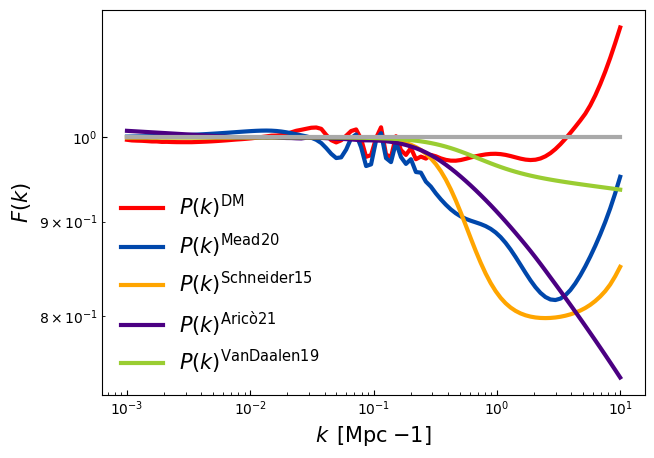

In [9]:
# List of vivid colors
colors = [
    "#FF0000",  # Vivid Red
    "#0047AB",  # Royal Blue
    "#FFA500",  # Vivid Orange
    "#4B0082",  # Indigo
    "#9ACD32",  # Yellow Green
    "#FF00FF"   # Magenta
]

# List of pk data and their labels
# Since we want pk / pk_nonlin, we should first get pk_nonlin data
pk_nonlin_data = pk_nonlin

pk_data = [
    (pk_dm/pk_nonlin_data, "$P(k)^\mathrm{DM}$"),
    (pk_hmcode/pk_nonlin_data, "$P(k)^\mathrm{Mead 20}$"),
    (pk_bcm/pk_nonlin_data, "$P(k)^\mathrm{Schneider 15}$"),
    (pk_bacco/pk_nonlin_data, "$P(k)^\mathrm{Aricò 21}$"),
    (pk_vd/pk_nonlin_data, "$P(k)^\mathrm{Van Daalen 19}$")
]

# Set the figure size
plt.figure(figsize=(7, 5))

# Loop over the pk data and colors to plot them
for (pk, label), color in zip(pk_data, colors):
    plt.loglog(k, pk, c=color, label=label, lw=3)

# Add the reference line for pk_nonlin / pk_nonlin = 1
plt.loglog(k, [1]*len(k), c="darkgray", lw=3)  # Using darkgray color for the reference line

# Setting the properties for ticks, labels, and legend
plt.gca().tick_params(direction='in', which='both')  # Ticks pointing inwards
plt.gca().yaxis.set_major_formatter(LogFormatterMathtext())  # Using Mathtext for y-axis labels
plt.xlabel("$k \: \: \mathrm{[Mpc ^ {-1}]}$", fontsize=15)
plt.ylabel("$F (k)$", fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.show()